In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Brief description of the problem and data
The goal of this project is to build a deep learning model to classify histopathologic images either containing cancer or not. The dataset used for this task is the ["Histopathologic Cancer Detection" dataset from Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/overview), which consists of labeled images of histopathologic image samples.

There are two classes in the dataset:
- Class 0: Images without cancer
- Class 1: Images with cancer

It has 220025 training images and 57458 test images, each of size 96x96 pixels in RGB format.  
Our goal is to build a model that can classify a image as either containing cancer or not with higher accuracy.


# Content
In this project, I will build the following models and compare their performance:  
Traditional ML:  
- Logistic Regression (GLCM features) according the feature extraction based on the above analysis.
- Logistic Regression (LBP features) according the feature extraction based on the above analysis.
- Random Forest (GLCM features) according the feature extraction based on the above analysis.
- Random Forest (LBP features) according the feature extraction based on the above analysis.

CNN:  
- Basic CNN
- Transfer Learning (ResNet50)
- Transfer Learning (DenseNet121)

# Import necessary libraries

In [2]:
# import library
from tqdm import tqdm # for fast, extensible progress bars for loops and iterables
tqdm.pandas()
import time

import pathlib as pl # for library path
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np

import random
import cv2 # you can also use from PIL import Image
import math
from typing import List, Optional, Tuple, Dict

# statistic
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp
import seaborn as sns
import matplotlib.pyplot as plt
    
# feature extraction
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# training LogisticRegression, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# training CNN
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalMaxPooling2D, 
                                     BatchNormalization, Dropout, Dense, Concatenate, Input,
                                     Conv2D, MaxPooling2D, Flatten)
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam


2025-09-13 01:11:51.648274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757725911.814641      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757725911.867322      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Prepared data
1. Data loading and preprocessing
2. Check data size and balance
3. Structure Check and Validation

In [5]:
# read data 
path = pl.Path("/kaggle/input/histopathologic-cancer-detection")
test = path/'test'
train = path/'train'
train_labels = path/'train_labels.csv'

train_df = pd.read_csv(train_labels)
train_list = train_df['id']

# get all test tif list
test_list = pd.Series(list(test.glob('*.tif')))
test_list = test_list.apply(lambda x: x.stem) # convert full path name to only file name
test_df = pd.DataFrame({'id': test_list})

print(type(train_list))
print(type(test_list))
print(f'There are {len(train_df)} training images and {len(test_df)} test images')
train_df.head()



<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
There are 220025 training images and 57458 test images


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 
There are something we can do before training:
1. Data distrubution: Check if the data (negative/positive) is balanced.
2. Image quality: make sure if the image size, color, format, file amount are normal.
3. Visualize some images to see if they are corrupted or not.

There are 89117 positive training images and 130908 negative training images.
Training data shape:
<class 'numpy.ndarray'>
(96, 96, 3)
<class 'tuple'>
Test data shape:
<class 'numpy.ndarray'>
(96, 96, 3)
<class 'tuple'>


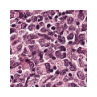

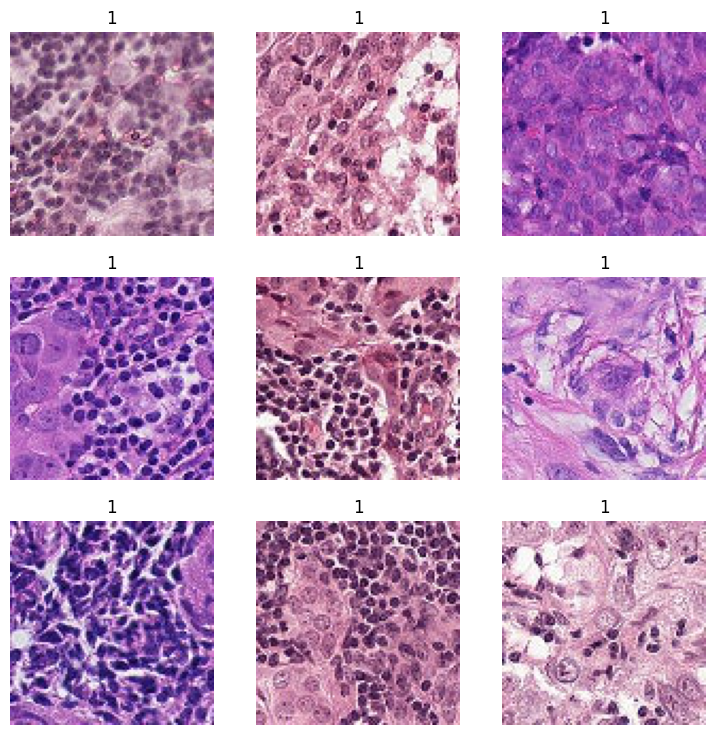

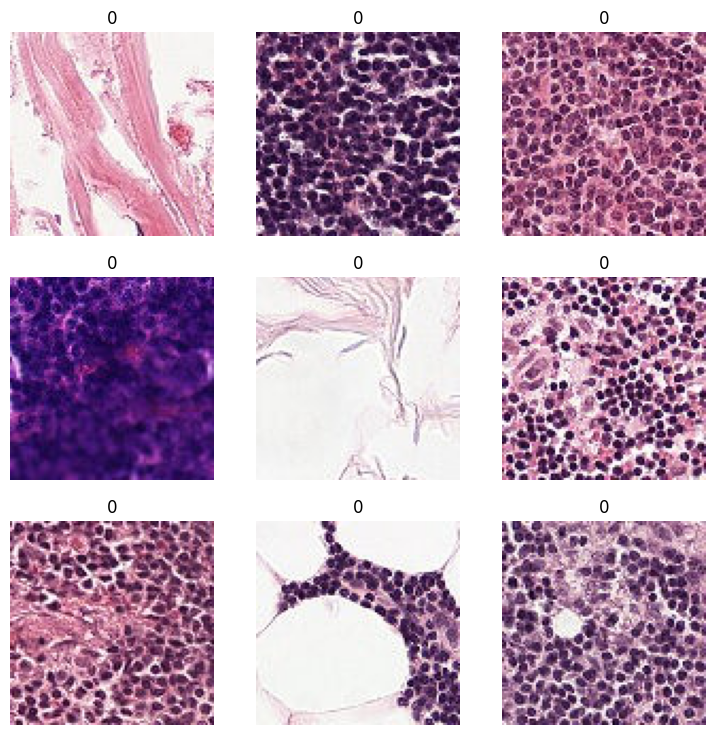

In [4]:
positive_n = train_df.label.sum()
negative_n = len(train_df) - positive_n
print(f'There are {positive_n} positive training images and {negative_n} negative training images.')

# check image quality 
im = cv2.imread(str(train / (train_df['id'][0] + '.tif')))
print('Training data shape:')
print(type(im))
print(im.shape)
print(type(im.shape))

im = cv2.imread(str(test / (test_df['id'][0] + '.tif')))
print('Test data shape:')
print(type(im))
print(im.shape)
print(type(im.shape))

img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1, 1))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

train_pos = train_df[train_df['label']==1].sample(9, random_state=42)
plt.figure(figsize=(9, 9))
for i, row in enumerate(train_pos.itertuples(), 1):
    ids = row.id
    label = row.label
    im = cv2.imread(str(train / (ids + '.tif')))
    img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    ax = plt.subplot(3, 3, i)
    plt.imshow(img_rgb)
    plt.title(str(label))
    plt.axis("off")

      
train_neg = train_df[train_df['label']==0].sample(9, random_state=42)
plt.figure(figsize=(9, 9))
for i, row in enumerate(train_neg.itertuples(), 1):
    ids = row.id
    label = row.label
    im = cv2.imread(str(train / (ids + '.tif')))
    img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    ax = plt.subplot(3, 3, i)
    plt.imshow(img_rgb)
    plt.title(str(label))
    plt.axis("off")

# Image feature Visualization
1. Lebel Distribution
2. Look at the average image pixel trends. 
3. Color channel distrubution.

## Label Distribution
**Althought there are more negative samples, this does not affect the average trend in this dataset and the following analysis.**

<Axes: title={'center': 'label distrubution'}, xlabel='label'>

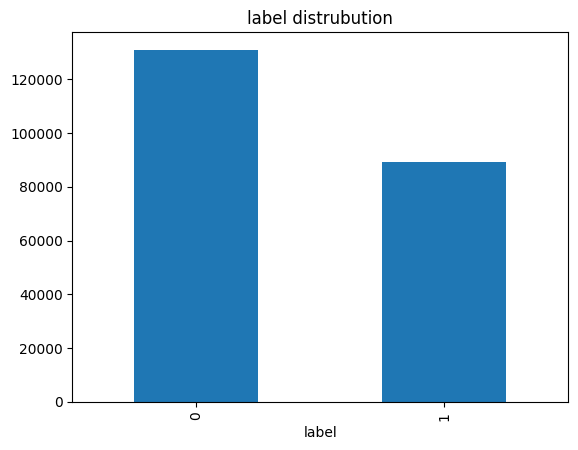

In [7]:
# label distribution
train_df['label'].value_counts().plot(title = 'label distrubution', kind='bar')

## The average image pixel distribution 
Then I did more analysis to see if we can use the RGB channel information to train a supervised learning model (one sample).  
> **The result shows that the RGB channel information may be useful for training a model. We can see positive sample have lower intensity, while negative sample have higher intensity.**

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 7.000e+00, 2.000e+00,
        9.000e+00, 1.400e+01, 1.400e+01, 2.200e+01, 2.600e+01, 2.600e+01,
        1.900e+01, 5.200e+01, 6.600e+01, 9.100e+01, 1.290e+02, 1.310e+02,
        1.960e+02, 2.730e+02, 3.350e+02, 4.010e+02, 4.330e+02, 5.670e+02,
        5.900e+02, 6.540e+02, 6.630e+02, 9.490e+02, 7.700e+02, 7.920e+02,
        8.150e+02, 7.600e+02, 7.980e+02, 8.040e+02, 9.430e+02, 9.500e+02,
        9.270e+02, 1.085e+03, 1.156e+03, 1.223e+03, 1.663e+03, 3.417e+03,
        3.163e+03, 2.699e+03]),
 array([  2.  ,   7.06,  12.12,  17.18,  22.24,  27.3 ,  32.36,  37.42,
         42.48,  47.54,  52.6 ,  57.66,  62.72,  67.78,  72.84,  77.9 ,
         82.96,  88.02,  93.08,  98.14, 103.2 , 108.26, 113.32, 118.38,
        123.44, 128.5 , 133.56, 138.62, 143.68, 148.74, 153.8 , 158.86,
        163.92, 168.98, 174.04, 179.1 , 184.16, 189.22, 194.28, 199.34,
        204.4 , 

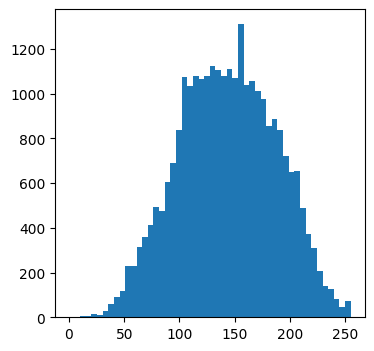

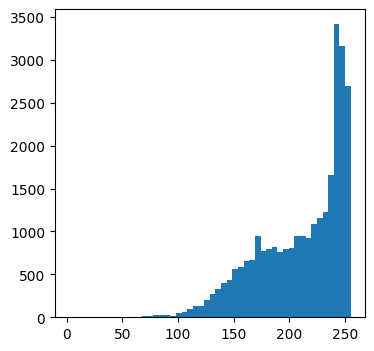

In [20]:
# Color channel distrubution
img = cv2.imread(str(train / (train_pos['id'].iloc[0] + '.tif')))
plt.figure(figsize=(4, 4))
plt.hist(img.ravel(), bins=50) # 50 sections and how many pixel in the section

img = cv2.imread(str(train / (train_neg['id'].iloc[0] + '.tif')))
plt.figure(figsize=(4, 4))
plt.hist(img.ravel(), bins=50) 

In [29]:
def get_pixels(image_ids, path):
        R, G, B = [], [], []
        for img_id in image_ids:
            img = cv2.imread(str(path / f"{img_id}.tif"))
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            R.extend(img[:,:,0].ravel())
            G.extend(img[:,:,1].ravel())
            B.extend(img[:,:,2].ravel())
        return R, G, B
    
# The function to draw the chart of the count of pixel intensity in three channel
def plot_rgb_hist(image_ids, plot_title, path, n_bins=50):
    R, G, B = get_pixels(image_ids, path)
    
    plt.figure(figsize=(8, 2))
    
    plt.subplot(1,3,1)
    plt.hist(R, bins=n_bins, range=(0,255), color='red', alpha=0.7)
    plt.title(f"{plot_title} - R channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")

    plt.subplot(1,3,2)
    plt.hist(G, bins=n_bins, range=(0,255), color='green', alpha=0.7)
    plt.title(f"{plot_title} - G channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")

    plt.subplot(1,3,3)
    plt.hist(B, bins=n_bins, range=(0,255), color='blue', alpha=0.7)
    plt.title(f"{plot_title} - B channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")


## Color channel distrubution
I also did some statistical test to see if the difference exist in divide RGB channel. I used 10 samples to check the distrubition in different channel.  
> **The result shows that if we look the three channels individually, the distrubition is also different in positive and negative samples. This means we may use RGB channel information to train a model.**

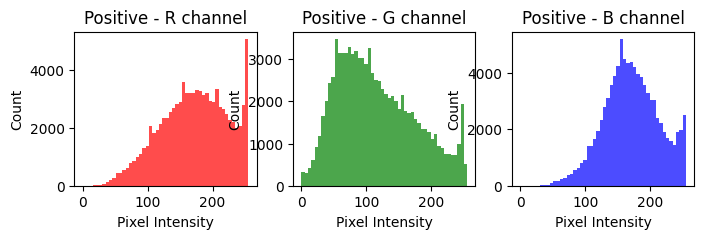

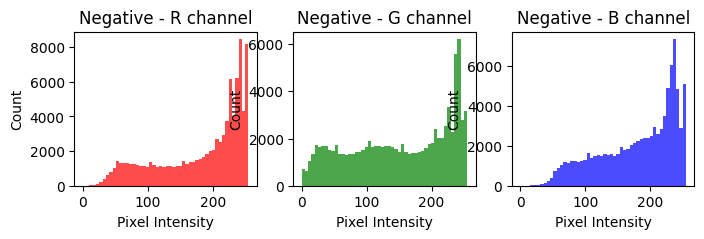

In [30]:
train_pos = train_df[train_df['label']==1].sample(10)['id']
train_neg = train_df[train_df['label']==0].sample(10)['id']

plot_rgb_hist(train_pos, "Positive", train)
plot_rgb_hist(train_neg, "Negative", train)


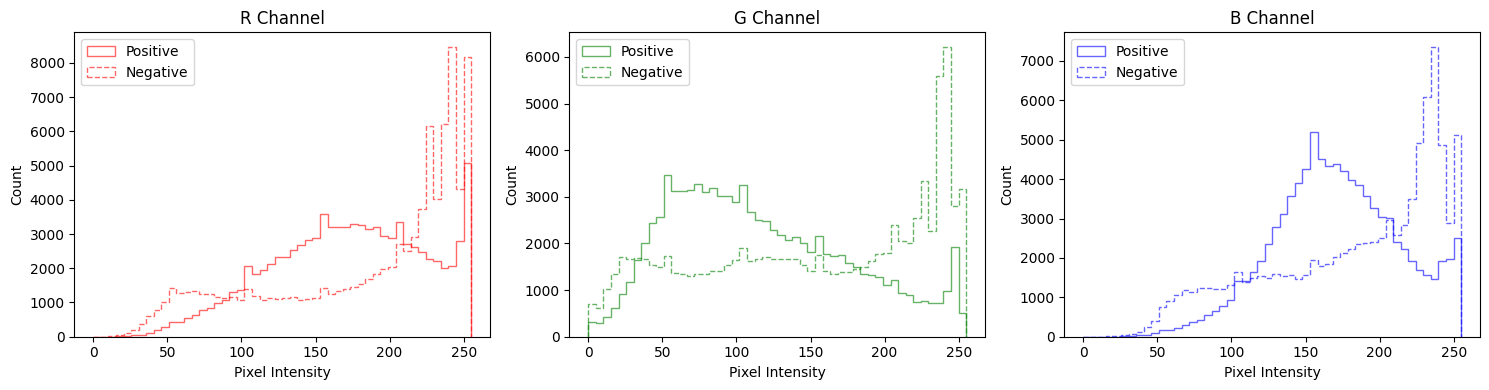

In [31]:
def plot_rgb_comparison(pos_ids, neg_ids, path, n_bins=50, density=False):
    R_pos, G_pos, B_pos = get_pixels(pos_ids, path)
    R_neg, G_neg, B_neg = get_pixels(neg_ids, path)
    
    plt.figure(figsize=(15,4))
    
    # R channel
    plt.subplot(1,3,1)
    plt.hist(R_pos, bins=n_bins, range=(0,255), color='red', density=density, alpha=0.6, histtype="step", label="Positive")
    plt.hist(R_neg, bins=n_bins, range=(0,255), color='red', density=density, alpha=0.6, linestyle="--", histtype="step", label="Negative")
    plt.title("R Channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")
    plt.legend()

    # G channel
    plt.subplot(1,3,2)
    plt.hist(G_pos, bins=n_bins, range=(0,255), color='green', density=density, alpha=0.6, histtype="step", label="Positive")
    plt.hist(G_neg, bins=n_bins, range=(0,255), color='green', density=density, alpha=0.6, linestyle="--", histtype="step", label="Negative")
    plt.title("G Channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")
    plt.legend()

    # B channel
    plt.subplot(1,3,3)
    plt.hist(B_pos, bins=n_bins, range=(0,255), color='blue', density=density, alpha=0.6, histtype="step", label="Positive")
    plt.hist(B_neg, bins=n_bins, range=(0,255), color='blue', density=density, alpha=0.6, linestyle="--", histtype="step", label="Negative")
    plt.title("B Channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_rgb_comparison(train_pos, train_neg, train)


# More data analysis
In the following analysis, I used 100 samples to do the analysis. The graphs also show the similar trend as above.  
So I used statistical tests to check if the difference exist in pixel values, divide RGB channel:   
- t-test  
- Mann-Whitney U test  
- Kolmogorov-Smirnov (KS) test  

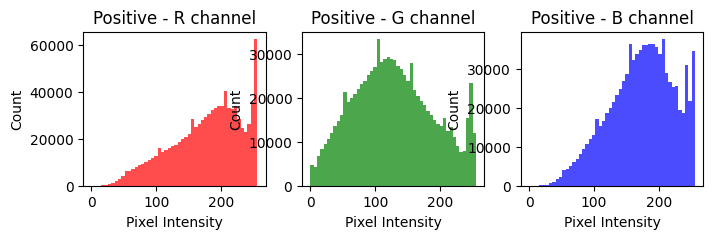

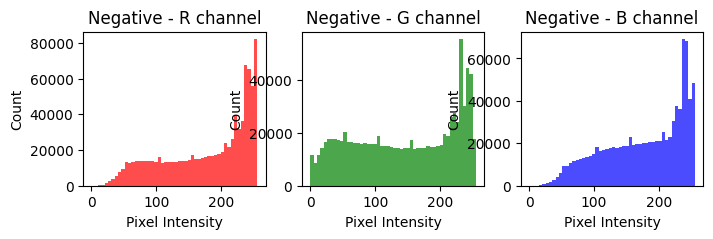

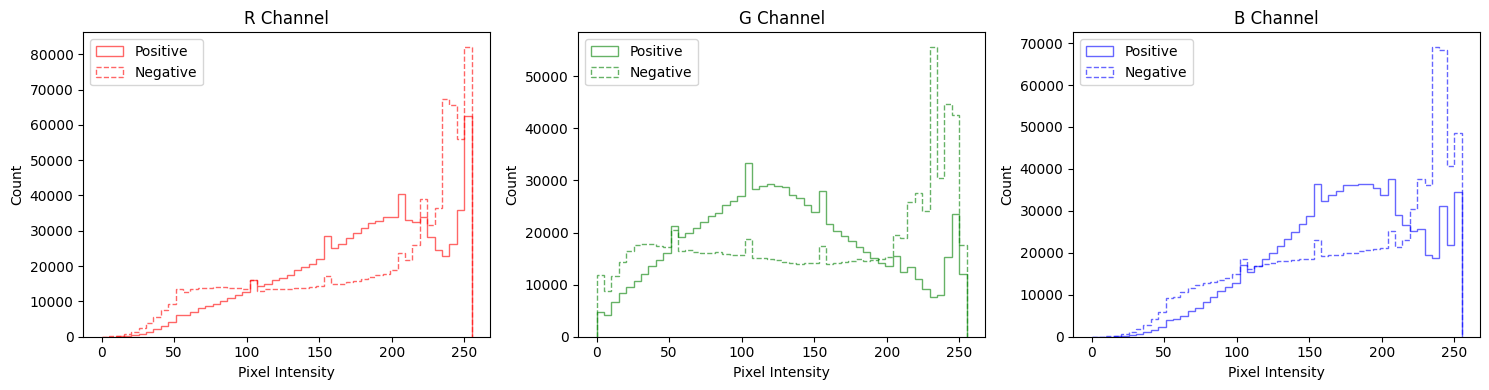

In [32]:
# Use more number of samples
train_pos = train_df[train_df['label']==1].sample(100)['id']
train_neg = train_df[train_df['label']==0].sample(100)['id']

plot_rgb_hist(train_pos, "Positive", train)
plot_rgb_hist(train_neg, "Negative", train)
plot_rgb_comparison(train_pos, train_neg, train)


## Statistical tests in RGB channel 
First, I looked at the average pixel value:  
Here is the result:  
- T-test: statistic=-1.4245, p=0.1561  
It means the average value is not different in positive and negative samples.    
- Mann-Whitney U: statistic=4700.0000, p=0.4643   
It means the median value is not different in positive and negative samples.    
- KS test: statistic=0.2600, p=0.00222  
**It means the distrubition shape is really different in positive and negative samples.**    

T-test: statistic=-1.4245, p=0.1561
Mann-Whitney U: statistic=4700.0000, p=0.4643
KS test: statistic=0.2600, p=0.00222


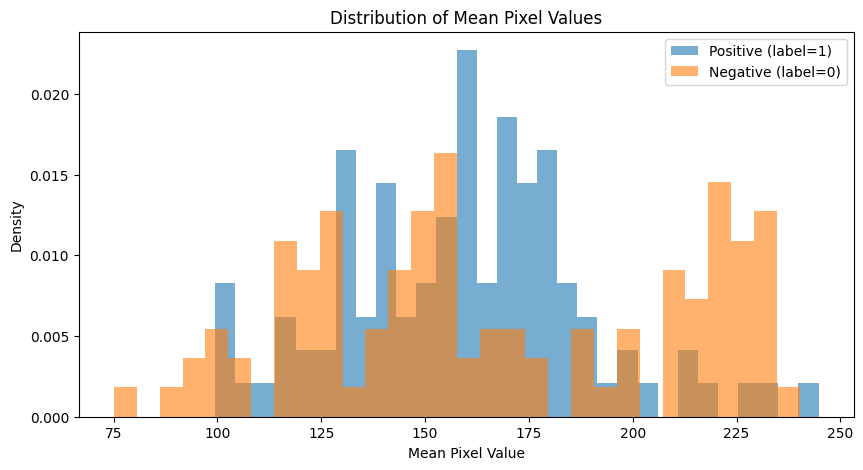

In [33]:
# combine all channel
def get_mean_pixel(img_id):
    img_path = train / f"{img_id}.tif"
    img_cv2 = cv2.imread(str(img_path))
    img = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    arr = np.array(img, dtype=np.float32)
    return arr.mean()
    
pos_pixels = [get_mean_pixel(i) for i in train_pos]
neg_pixels = [get_mean_pixel(i) for i in train_neg]

# statistic
t_stat, t_p = ttest_ind(pos_pixels, neg_pixels, equal_var=False)
u_stat, u_p = mannwhitneyu(pos_pixels, neg_pixels, alternative='two-sided')
ks_stat, ks_p = ks_2samp(pos_pixels, neg_pixels)

print("T-test: statistic=%.4f, p=%.4g" % (t_stat, t_p))
print("Mann-Whitney U: statistic=%.4f, p=%.4g" % (u_stat, u_p))
print("KS test: statistic=%.4f, p=%.4g" % (ks_stat, ks_p))

plt.figure(figsize=(10,5))

plt.hist(pos_pixels, bins=30, alpha=0.6, label='Positive (label=1)', density=True)
plt.hist(neg_pixels, bins=30, alpha=0.6, label='Negative (label=0)', density=True)

plt.title("Distribution of Mean Pixel Values")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Density")
plt.legend()
plt.show()


Then I divided the image into three channels: R, G, B. I did the same analysis in each channel.    
=== Channel R ===    
T-test: statistic=-0.8953, p=0.3719    
Mann-Whitney U: statistic=4756.0000, p=0.5519    
KS test: statistic=0.2600, p=0.00222    

=== Channel G ===    
T-test: statistic=-2.5207, p=0.01261    
Mann-Whitney U: statistic=4278.0000, p=0.07792    
KS test: statistic=0.2800, p=0.0007377    

=== Channel B ===    
T-test: statistic=-0.3635, p=0.7167    
Mann-Whitney U: statistic=4847.0000, p=0.7094    
KS test: statistic=0.2600, p=0.00222    

> **We can see that in all of the three channels, the distrubition shape is different in positive and negative samples. However, the blue channel has the most significant difference. This means if we use B channel information to train a supervised learding model, we may get the better result than using R,G channels.**


=== Channel R ===
T-test: statistic=-0.8953, p=0.3719
Mann-Whitney U: statistic=4756.0000, p=0.5519
KS test: statistic=0.2600, p=0.00222

=== Channel G ===
T-test: statistic=-2.5207, p=0.01261
Mann-Whitney U: statistic=4278.0000, p=0.07792
KS test: statistic=0.2800, p=0.0007377

=== Channel B ===
T-test: statistic=-0.3635, p=0.7167
Mann-Whitney U: statistic=4847.0000, p=0.7094
KS test: statistic=0.2600, p=0.00222


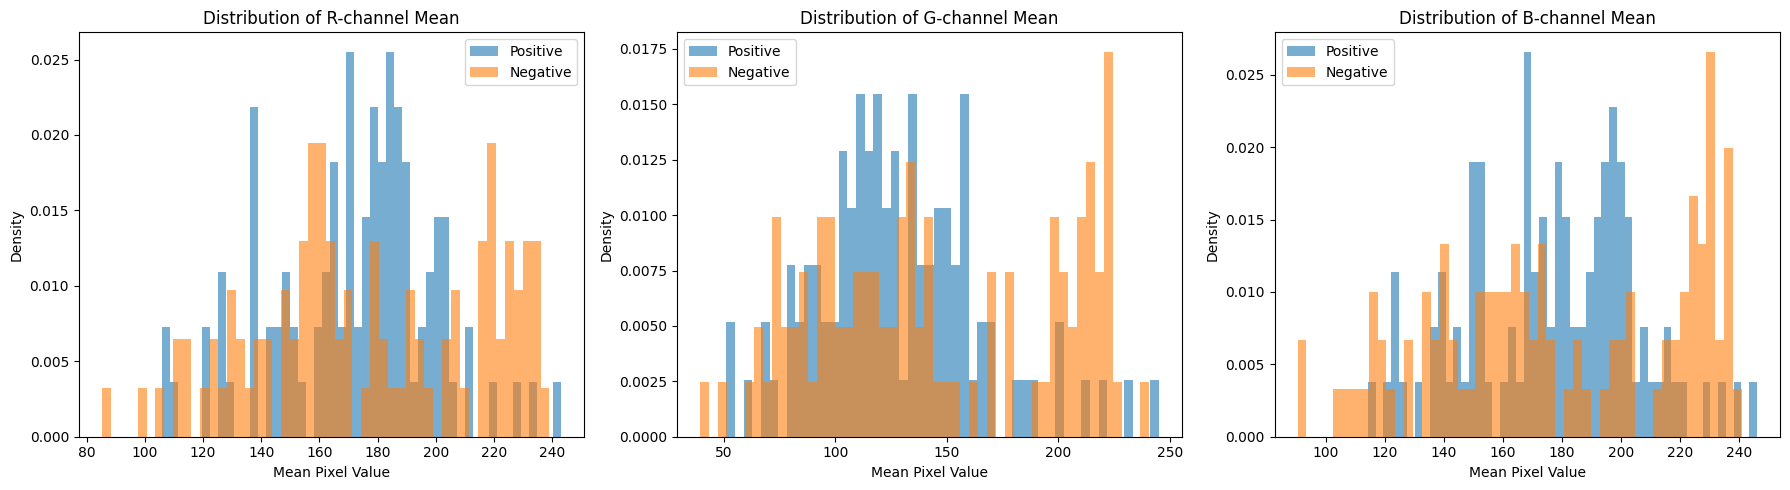

In [34]:
# divide into three channels
def get_mean_pixel_channel(img_id):
    img_path = train / f"{img_id}.tif"
    # img = Image.open(img_path).convert("RGB")  # three channel
    img_cv2 = cv2.imread(str(img_path))
    arr = np.array(img_cv2, dtype=np.float32)
    return arr.mean(axis=(0,1))   # shape (3,)
    
pos_pixels = np.array([get_mean_pixel_channel(i) for i in train_pos])  # shape (N,3)
neg_pixels = np.array([get_mean_pixel_channel(i) for i in train_neg])  # shape (N,3)

channels = ["R", "G", "B"]

# statistic
for idx, ch in enumerate(channels):
    print(f"\n=== Channel {ch} ===")
    t_stat, t_p = ttest_ind(pos_pixels[:, idx], neg_pixels[:, idx], equal_var=False)
    u_stat, u_p = mannwhitneyu(pos_pixels[:, idx], neg_pixels[:, idx], alternative='two-sided')
    ks_stat, ks_p = ks_2samp(pos_pixels[:, idx], neg_pixels[:, idx])

    print("T-test: statistic=%.4f, p=%.4g" % (t_stat, t_p))
    print("Mann-Whitney U: statistic=%.4f, p=%.4g" % (u_stat, u_p))
    print("KS test: statistic=%.4f, p=%.4g" % (ks_stat, ks_p))

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for idx, ch in enumerate(channels):
    axes[idx].hist(pos_pixels[:, idx], bins=50, alpha=0.6, label='Positive', density=True)
    axes[idx].hist(neg_pixels[:, idx], bins=50, alpha=0.6, label='Negative', density=True)
    axes[idx].set_title(f"Distribution of {ch}-channel Mean")
    axes[idx].set_xlabel("Mean Pixel Value")
    axes[idx].set_ylabel("Density")
    axes[idx].legend()

plt.tight_layout()
plt.show()


# Feature extraction 
Based on the above analysis, I think we can use B channel information to train a supervised regression model.   
I used two methods to extract features: Gray Level Co-occurrence Matrix (GLCM) and Local Binary Patterns (LBP).  
These two methods are commonly used in image processing and computer vision to extract texture features from gray images.  

In [13]:
def show_heatmap(cm): 
    # Create the heatmap
    plt.figure(figsize=(6, 5)) # Adjust figure size as needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                    yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
    
def load_img_B(img_id):
    img_path = train / f"{img_id}.tif"
    # img = Image.open(img_path).convert("RGB")
    img = cv2.imread(str(img_path))
    arr = np.asarray(img, dtype=np.uint8)
    return arr[:, :, 1]
    
def quantize(img, levels=32):
    return (img.astype(np.uint16) * (levels - 1) // 255).astype(np.uint8)

def glcm_features(img, levels=32, distances=(1, 2, 3), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    q = quantize(img, levels=levels)
    glcm = graycomatrix(q, 
                        distances=distances, 
                        angles=angles, 
                        levels=levels, 
                        symmetric=True, 
                        normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    feats = []
    for p in props:
        vals = graycoprops(glcm, p).ravel()  # shape: len(distances)*len(angles)
        feats.append(vals.mean())
        feats.append(vals.std())
    return np.array(feats, dtype=np.float32)

def lbp_features(img, P=8, R=1.0, method='uniform'):
    lbp = local_binary_pattern(img, P=P, R=R, method=method)
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

X_glcm = []
X_lbp = []
y = []

train_df_sample = train_df.sample(1000)

for img_id, lab in tqdm(zip(train_df_sample['id'], train_df_sample['label']), total=len(train_df_sample)):
    g = load_img_B(img_id)
    X_glcm.append(glcm_features(g, levels=32, distances=(1,2,3), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)))
    X_lbp.append(lbp_features(g, P=8, R=1.0, method='uniform'))
    y.append(lab)

X_glcm = np.vstack(X_glcm)
X_lbp = np.vstack(X_lbp)
y = np.array(y)

print("GLCM shape:", X_glcm.shape)  # (N, 6 props * 2 stats * len(dist)*len(ang) collapsed -> 12 per prop => 12*6=72? 實際為 mean/std 後 -> 12 cols)
print("LBP  shape:", X_lbp.shape) 


100%|██████████| 1000/1000 [00:15<00:00, 64.47it/s]

GLCM shape: (1000, 12)
LBP  shape: (1000, 10)


In [14]:
RANDOM_STATE = 42

Xg_tr, Xg_va, yg_tr, yg_va = train_test_split(X_glcm, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
Xl_tr, Xl_va, yl_tr, yl_va = train_test_split(X_lbp,  y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


# Logistic Regression  
First, I used logistic regression to do the classification.
The result shows that the accuracy is around 70-80%. 
- The accuracy of using GLCM features is about 0.775
- The accuracy of using LBP features is about 0.705


=== Logistic Regression (GLCM) ===
ACC: 0.775
AUC: 0.8662670525010335
[[87 31]
 [14 68]]
              precision    recall  f1-score   support

           0     0.8614    0.7373    0.7945       118
           1     0.6869    0.8293    0.7514        82

    accuracy                         0.7750       200
   macro avg     0.7741    0.7833    0.7730       200
weighted avg     0.7898    0.7750    0.7768       200



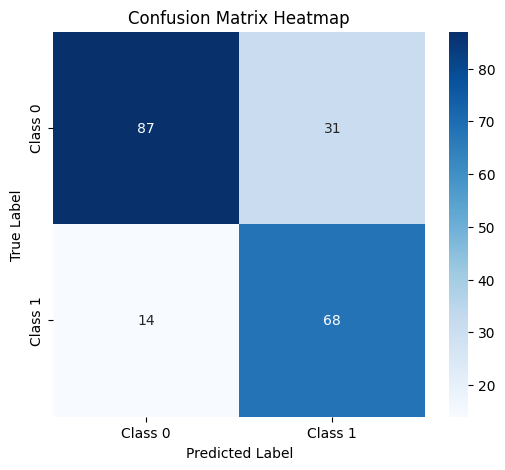


=== Logistic Regression (LBP) ===
ACC: 0.705
AUC: 0.8052914427449358
[[77 41]
 [18 64]]
              precision    recall  f1-score   support

           0     0.8105    0.6525    0.7230       118
           1     0.6095    0.7805    0.6845        82

    accuracy                         0.7050       200
   macro avg     0.7100    0.7165    0.7037       200
weighted avg     0.7281    0.7050    0.7072       200



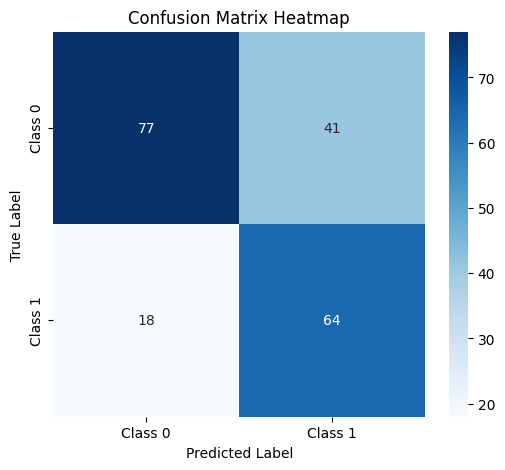

In [15]:
scaler_g = StandardScaler().fit(Xg_tr)
Xg_tr_s = scaler_g.transform(Xg_tr)
Xg_va_s = scaler_g.transform(Xg_va)

scaler_l = StandardScaler().fit(Xl_tr)
Xl_tr_s = scaler_l.transform(Xl_tr)
Xl_va_s = scaler_l.transform(Xl_va)

lr_g = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)
lr_l = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)

lr_g.fit(Xg_tr_s, yg_tr)
lr_l.fit(Xl_tr_s, yl_tr)

pred_g = lr_g.predict(Xg_va_s)
proba_g = lr_g.predict_proba(Xg_va_s)[:,1]
pred_l = lr_l.predict(Xl_va_s)
proba_l = lr_l.predict_proba(Xl_va_s)[:,1]

print("\n=== Logistic Regression (GLCM) ===")
print("ACC:", accuracy_score(yg_va, pred_g))
print("AUC:", roc_auc_score(yg_va, proba_g))
cm = confusion_matrix(yg_va, pred_g)
print(cm)
print(classification_report(yg_va, pred_g, digits=4))
show_heatmap(cm)

print("\n=== Logistic Regression (LBP) ===")
print("ACC:", accuracy_score(yl_va, pred_l))
print("AUC:", roc_auc_score(yl_va, proba_l))
cm = confusion_matrix(yl_va, pred_l)
print(cm)
print(classification_report(yl_va, pred_l, digits=4))
show_heatmap(cm)


# Random Forest
Then, I used random forest to do the classification.
The result shows that the accuracy is around 70-80%. 
- The accuracy of using GLCM features is about 0.785
- The accuracy of using LBP features is about 0.73


=== RandomForest (GLCM) ===
ACC: 0.785
AUC: 0.8612546506821
[[77 41]
 [18 64]]
              precision    recall  f1-score   support

           0     0.8151    0.8220    0.8186       118
           1     0.7407    0.7317    0.7362        82

    accuracy                         0.7850       200
   macro avg     0.7779    0.7769    0.7774       200
weighted avg     0.7846    0.7850    0.7848       200



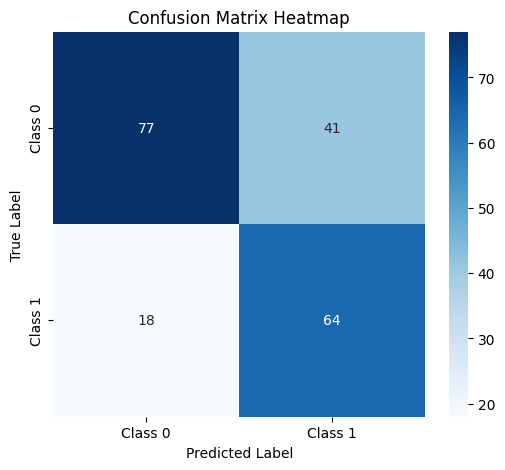


=== RandomForest (LBP) ===
ACC: 0.73
AUC: 0.801829268292683
[[95 23]
 [31 51]]
              precision    recall  f1-score   support

           0     0.7540    0.8051    0.7787       118
           1     0.6892    0.6220    0.6538        82

    accuracy                         0.7300       200
   macro avg     0.7216    0.7135    0.7163       200
weighted avg     0.7274    0.7300    0.7275       200



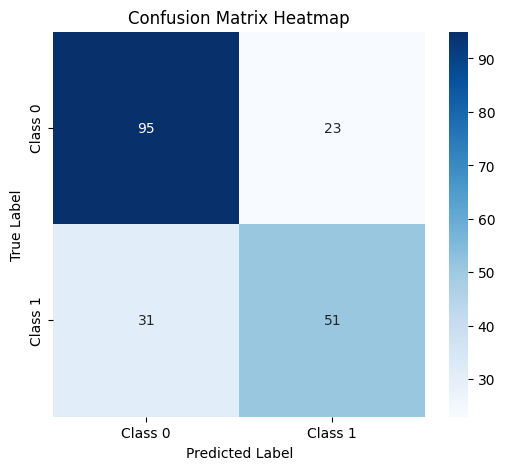

In [18]:
rf_g = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
rf_l = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

rf_g.fit(Xg_tr, yg_tr)
rf_l.fit(Xl_tr, yl_tr)

pred_g_rf = rf_g.predict(Xg_va)
proba_g_rf = rf_g.predict_proba(Xg_va)[:,1]
pred_l_rf = rf_l.predict(Xl_va)
proba_l_rf = rf_l.predict_proba(Xl_va)[:,1]

print("\n=== RandomForest (GLCM) ===")
print("ACC:", accuracy_score(yg_va, pred_g_rf))
print("AUC:", roc_auc_score(yg_va, proba_g_rf))
cm = confusion_matrix(yl_va, pred_l)
print(cm)
print(classification_report(yg_va, pred_g_rf, digits=4))
show_heatmap(cm)

print("\n=== RandomForest (LBP) ===")
print("ACC:", accuracy_score(yl_va, pred_l_rf))
print("AUC:", roc_auc_score(yl_va, proba_l_rf))
cm = confusion_matrix(yl_va, pred_l_rf)
print(cm)
print(classification_report(yl_va, pred_l_rf, digits=4))
show_heatmap(cm)

# Prepare CNN Data
Finally, I prepared the data for CNN model training. I used 10000 samples to do the training and validation. The data is normalized and split into training and validation sets.

In [42]:
N_SAMPLES = 10000
train_df_small = train_df.sample(N_SAMPLES, random_state=42)

train_df_sb, val_df_sb = train_test_split(train_df_small, test_size=0.2, stratify=train_df_small['label'], random_state=42)
train_df_sb['label'] = train_df_sb['label'].astype(str)
train_df_sb['filename'] = train_df_sb['id'] + ".tif"
val_df_sb['label'] = val_df_sb['label'].astype(str)
val_df_sb['filename'] = val_df_sb['id'] + ".tif"

# Data Preparation
IMG_SIZE = 96
EPOCHS = 20

train_datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    zoom_range=0.1)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_sb,
    directory=str(train),
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    class_mode="binary",
    batch_size=64,
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df_sb,
    directory=str(train),
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    class_mode="binary",
    batch_size=64,
    shuffle=False
)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


# Convolution neural network(CNN) 
I built a simple CNN model with 10 layers with 3 convolution layers, 3 max pooling layers, 1 flatten layer, 2 fully connected layers(dense) and 1 dropout layer.  
The model is trained for 20 epochs. The learning rate is set to 0.001 and the optimizer used is Adam. The loss function used is binary cross-entropy loss.

**The result shows that the accuracy is 81.44% in the latest epoch.**

In [43]:
# model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1757690350.892805     160 service.cc:148] XLA service 0x7def20005690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757690350.893587     160 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757690351.235314     160 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/125 ━━━━━━━━━━━━━━━━━━━━ 12:08 6s/step - accuracy: 0.4219 - loss: 0.7177

I0000 00:00:1757690354.030562     160 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 805ms/step - accuracy: 0.6276 - loss: 0.6463 - val_accuracy: 0.7790 - val_loss: 0.4865
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 276ms/step - accuracy: 0.7707 - loss: 0.4961 - val_accuracy: 0.7555 - val_loss: 0.5608
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 275ms/step - accuracy: 0.7849 - loss: 0.4714 - val_accuracy: 0.7970 - val_loss: 0.4511
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 274ms/step - accuracy: 0.7838 - loss: 0.4738 - val_accuracy: 0.6950 - val_loss: 0.5931
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 273ms/step - accuracy: 0.7933 - loss: 0.4597 - val_accuracy: 0.7935 - val_loss: 0.4530
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 273ms/step - accuracy: 0.7891 - loss: 0.4651 - val_accuracy: 0.7790 - val_loss: 0.4833
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 273ms/step - accuracy: 0.7975 - loss: 0.4498 - val_accuracy: 0.7795 - val_loss: 0.4739
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 273ms/step - accuracy: 0.8043 - loss: 0.4299 - va

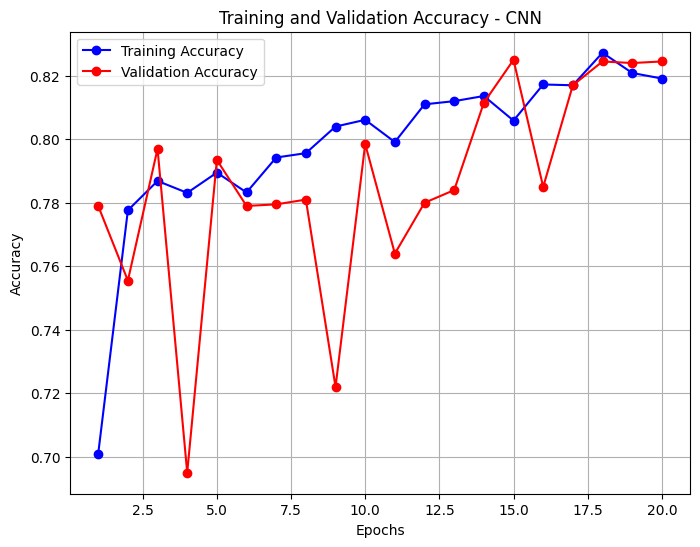

In [44]:
# train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

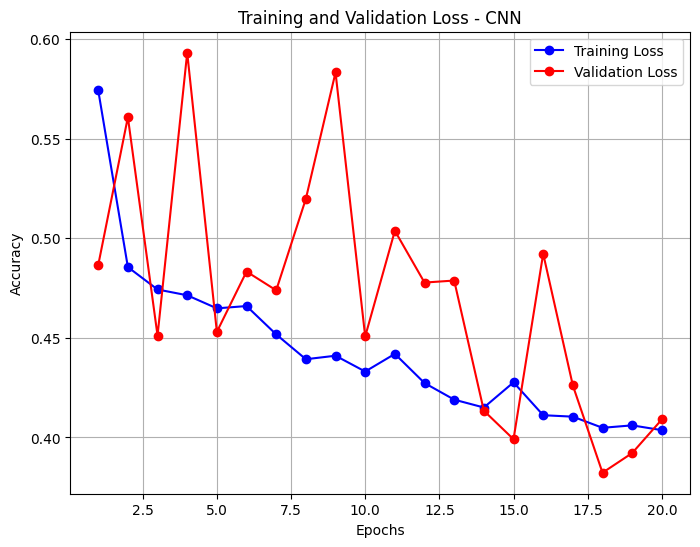

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss - CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Transfer Learning - ResNet50
I also tried to use transfer learning to do the classification. I used ResNet50 as the base model and add global average pooling and global max pooling, concatenated their outputs, applied batch normalization, dropout, and a dense layer with 1024 units and ReLU activation. The model is trained for 20 epochs. The learning rate is set to 0.0001 and the optimizer used is Adam. The loss function used is binary cross-entropy loss.  
**The result shows that the accuracy is around 77.36% in the latest epoch.**

In [48]:
def build_resnet50_transfer(input_shape=(224, 224, 3)):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

    # Freeze first N layers 
    for layer in base_model.layers[:140]:
        layer.trainable = False
    for layer in base_model.layers[140:]:
        layer.trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    x = Concatenate()([avg_pool, max_pool])
    
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs, name='ResNet50_finetune')

    return model

In [49]:
model_transfer_learning = build_resnet50_transfer(input_shape=(96, 96, 3))

model_transfer_learning.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_transfer_learning.summary()

Model: "ResNet50_finetune"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 3, 3,      │ 23,587,712 │ input_layer_5[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096)      │     16,384 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 4096)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │  4,195,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │      1,025 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,804,545 (106.07 MB)

 Trainable params: 19,184,641 (73.18 MB)

 Non-trainable params: 8,619,904 (32.88 MB)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - accuracy: 0.7246 - auc: 0.8001 - loss: 0.5647 - val_accuracy: 0.7860 - val_auc: 0.8574 - val_loss: 0.4696 - learning_rate: 2.5000e-05
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 279ms/step - accuracy: 0.7427 - auc: 0.8167 - loss: 0.5389 - val_accuracy: 0.7870 - val_auc: 0.8578 - val_loss: 0.4691 - learning_rate: 2.5000e-05
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 276ms/step - accuracy: 0.7520 - auc: 0.8188 - loss: 0.5314 - val_accuracy: 0.6575 - val_auc: 0.7662 - val_loss: 0.9606 - learning_rate: 2.5000e-05
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 272ms/step - accuracy: 0.7346 - auc: 0.8033 - loss: 0.5624 - val_accuracy: 0.7660 - val_auc: 0.8458 - val_loss: 0.5301 - learning_rate: 2.5000e-05
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7489 - auc: 0.8177 - loss: 0.5376
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 276ms/step - accuracy: 0.

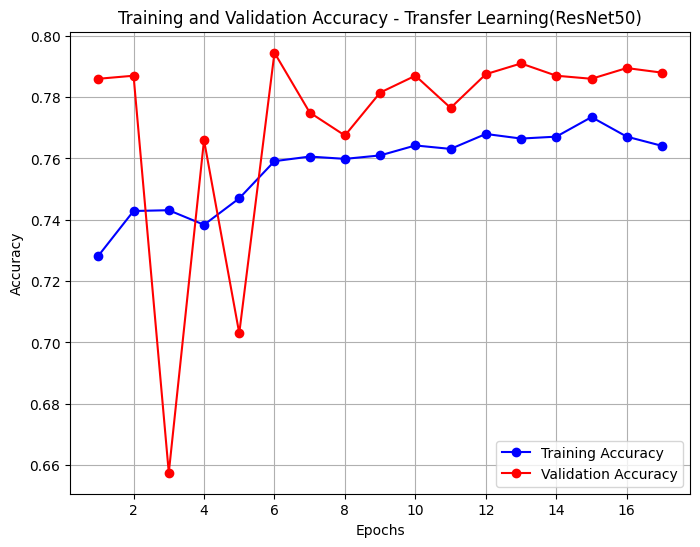

In [54]:
history_transfer_learning = model_transfer_learning.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_auc', patience=5, mode="max", restore_best_weights=True),
    ]
)

acc = history_transfer_learning.history['accuracy']
val_acc = history_transfer_learning.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - Transfer Learning(ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

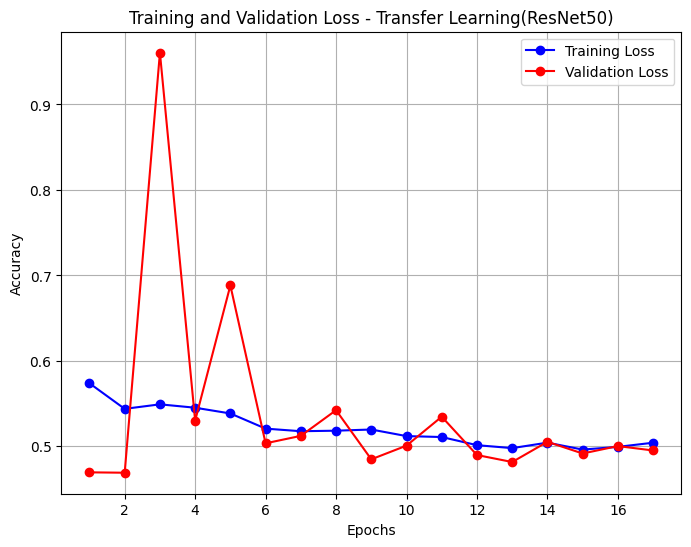

In [55]:
loss = history_transfer_learning.history['loss']
val_loss = history_transfer_learning.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss - Transfer Learning(ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Transfer Learning - DenseNet121
I also tried to use DenseNet121 as the base model and all of other configurations are the same as above.
**The result shows that the accuracy is around 84.55% in the latest epoch.**

In [ ]:
def build_rdensenet121_transfer(input_shape=(96, 96, 3)):
    base_model = DenseNet121(weights="imagenet", 
                         include_top=False, 
                         input_shape=input_shape)

    base_model.trainable = False
    
    inputs = Input(shape=(96, 96, 3))
    x = base_model(inputs, training=False)
    
    # Global Average + Max Pooling
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    x = Concatenate()([avg_pool, max_pool])
    
    # Dense Block 1
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation="relu")(x)

    # Dense Block 2
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Final Output
    outputs = Dense(1, activation="sigmoid")(x)
    
    model = models.Model(inputs, outputs)
    return model


In [ ]:
model_densenet21 = build_rdensenet121_transfer(input_shape=(96, 96, 3))

model_densenet21.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model_densenet21.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 3, 3,      │  7,037,504 │ input_layer_11[0… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 2048)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ concatenate_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 2048)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        257 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,571,521 (28.88 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 7,042,112 (26.86 MB)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 463ms/step - accuracy: 0.6592 - loss: 0.7624 - val_accuracy: 0.7385 - val_loss: 0.5237 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 292ms/step - accuracy: 0.7701 - loss: 0.5417 - val_accuracy: 0.8120 - val_loss: 0.4201 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 288ms/step - accuracy: 0.7898 - loss: 0.4911 - val_accuracy: 0.8295 - val_loss: 0.3932 - learning_rate: 1.0000e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.7924 - loss: 0.4876 - val_accuracy: 0.8335 - val_loss: 0.3702 - learning_rate: 1.0000e-04
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.8084 - loss: 0.4595 - val_accuracy: 0.8450 - val_loss: 0.3518 - learning_rate: 1.0000e-04
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0.8184 - loss: 0.4231 - val_accuracy: 0.8600 - val_loss: 0.3366 - learning_rate: 1.0000e-04
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 28

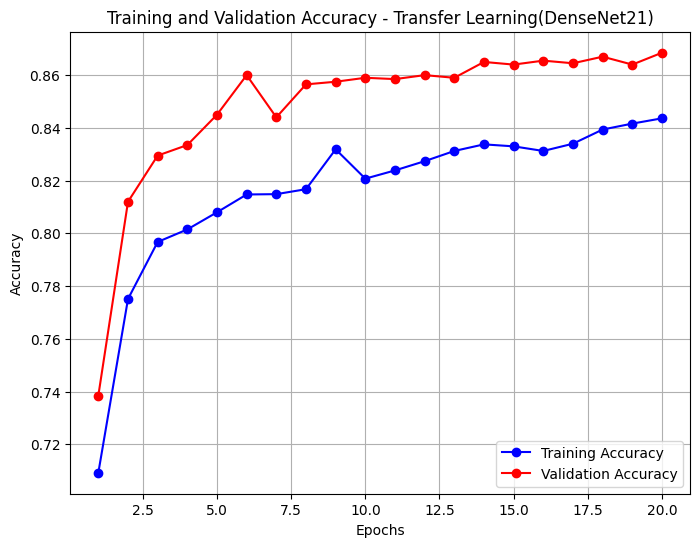

In [61]:
# accuracy,loss,val_accuracy,val_loss,learning_rate
history_densenet21 = model_densenet21.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5,  patience=3, min_lr=1e-7, verbose=1)]
)

acc = history_densenet21.history['accuracy']
val_acc = history_densenet21.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - Transfer Learning(DenseNet21)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

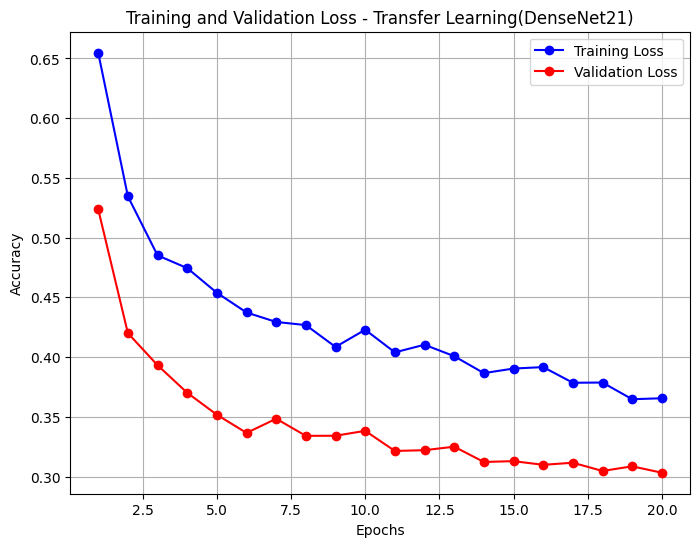

In [62]:
loss = history_densenet21.history['loss']
val_loss = history_densenet21.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss - Transfer Learning(DenseNet21)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion
| Model | Accuracy |
|-------|----------|
| Logistic Regression (GLCM features) | ~77.5% |
| Logistic Regression (LBP features) | ~70.5% |
| Random Forest (GLCM features) | ~78.5% |
| Random Forest (LBP features) | ~73% |
| CNN | ~81.44% |
| Transfer Learning (ResNet50) | ~77.36% |
| Transfer Learning (DenseNet121) | ~84.78% |

In this project, I built several models to classify histopathologic images either containing cancer or not. I started with logistic regression and random forest using GLCM and LBP features, achieving around 70-80% accuracy. Then, I built a simple CNN model that achieved 81.44% accuracy. Finally, I explored transfer learning with ResNet50 and DenseNet121, with DenseNet121 achieving the highest accuracy of 84.78%. Overall, the deep learning approaches outperformed traditional machine learning methods in this task.performed traditional machine learning methods in this task.


# Submission

In [25]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 128

def load_and_preprocess(img_path):
    img = cv2.imread(str(img_path))                  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      
    img = cv2.resize(img, IMG_SIZE)                 
    arr = img.astype(np.float32) / 255.0            
    return arr

def batch_generator(img_ids, batch_size=128):
    n = len(img_ids)
    for i in range(0, n, batch_size):
        batch_ids = img_ids[i:i+batch_size]
        batch_imgs = [load_and_preprocess(test / f"{img_id}.tif") for img_id in batch_ids]
        yield np.array(batch_imgs)

y_pred_list = []
for batch_imgs in tqdm(batch_generator(test_df['id'], batch_size=128), desc="Predicting"):
    y_pred_batch = model_densenet21.predict(batch_imgs)
    y_pred_list.append(y_pred_batch)

y_pred = np.vstack(y_pred_list)
y_label = (y_pred.ravel() > 0.5).astype(int)

submission = pd.DataFrame({
    "id": test_df['id'],
    "label": y_label
})
submission.to_csv("sample_submission.csv", index=False)

Predicting: 0it [00:00, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step


Predicting: 1it [00:15, 15.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 2it [00:16,  7.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 3it [00:18,  4.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 4it [00:19,  3.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 5it [00:20,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 6it [00:21,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 7it [00:22,  1.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 8it [00:24,  1.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 9it [00:25,  1.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 10it [00:26,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 11it [00:27,  1.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 12it [00:29,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 13it [00:30,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 14it [00:31,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 15it [00:33,  1.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 16it [00:34,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 17it [00:35,  1.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 18it [00:37,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 19it [00:38,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 20it [00:39,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 21it [00:40,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 22it [00:42,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 23it [00:43,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 24it [00:44,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 25it [00:45,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 26it [00:47,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 27it [00:48,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 28it [00:49,  1.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 29it [00:50,  1.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 30it [00:51,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 31it [00:52,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 32it [00:54,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 33it [00:55,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 34it [00:56,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 35it [00:57,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 36it [00:58,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 37it [00:59,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 38it [01:00,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 39it [01:02,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 40it [01:03,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 41it [01:04,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 42it [01:05,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 43it [01:06,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 44it [01:07,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 45it [01:08,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 46it [01:09,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 47it [01:10,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 48it [01:12,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 49it [01:13,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 50it [01:14,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 51it [01:15,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 52it [01:16,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 53it [01:17,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 54it [01:19,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 55it [01:20,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting: 56it [01:21,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 57it [01:22,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 58it [01:23,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 59it [01:24,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 60it [01:26,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 61it [01:27,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 62it [01:28,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 63it [01:29,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 64it [01:30,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 65it [01:31,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting: 66it [01:32,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 67it [01:33,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 68it [01:35,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 69it [01:36,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 70it [01:37,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 71it [01:38,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 72it [01:39,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 73it [01:40,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 74it [01:41,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 75it [01:42,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 76it [01:43,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 77it [01:44,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 78it [01:46,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 79it [01:47,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 80it [01:48,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 81it [01:49,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 82it [01:50,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 83it [01:51,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 84it [01:52,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 85it [01:53,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 86it [01:54,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 87it [01:55,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 88it [01:56,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 89it [01:57,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 90it [01:59,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 91it [02:00,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 92it [02:01,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 93it [02:02,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 94it [02:03,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 95it [02:04,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 96it [02:05,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 97it [02:06,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 98it [02:07,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 99it [02:08,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 100it [02:09,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 101it [02:10,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 102it [02:11,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 103it [02:12,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 104it [02:13,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 105it [02:14,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 106it [02:15,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 107it [02:16,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 108it [02:18,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 109it [02:19,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 110it [02:20,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 111it [02:21,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 112it [02:22,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 113it [02:23,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 114it [02:24,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 115it [02:25,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 116it [02:26,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 117it [02:27,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 118it [02:28,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 119it [02:30,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 120it [02:31,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting: 121it [02:32,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 122it [02:33,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 123it [02:35,  1.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 124it [02:36,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 125it [02:37,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 126it [02:38,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 127it [02:40,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 128it [02:41,  1.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 129it [02:42,  1.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 130it [02:43,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 131it [02:44,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 132it [02:45,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 133it [02:46,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 134it [02:47,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 135it [02:48,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 136it [02:49,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 137it [02:51,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 138it [02:52,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 139it [02:53,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 140it [02:54,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 141it [02:55,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 142it [02:56,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 143it [02:57,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 144it [02:58,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 145it [02:59,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 146it [03:00,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 147it [03:01,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 148it [03:02,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 149it [03:03,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 150it [03:04,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 151it [03:05,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 152it [03:06,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 153it [03:07,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 154it [03:09,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 155it [03:10,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 156it [03:11,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 157it [03:12,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 158it [03:13,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 159it [03:14,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 160it [03:15,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 161it [03:16,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 162it [03:17,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 163it [03:18,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 164it [03:20,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 165it [03:21,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 166it [03:22,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 167it [03:23,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 168it [03:24,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 169it [03:25,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 170it [03:26,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 171it [03:28,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 172it [03:29,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 173it [03:30,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 174it [03:31,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 175it [03:32,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 176it [03:33,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 177it [03:34,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 178it [03:35,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 179it [03:37,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 180it [03:38,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 181it [03:39,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 182it [03:40,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 183it [03:41,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 184it [03:42,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 185it [03:43,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 186it [03:44,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 187it [03:45,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 188it [03:46,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 189it [03:47,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 190it [03:49,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 191it [03:50,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 192it [03:51,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 193it [03:52,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 194it [03:53,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 195it [03:54,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 196it [03:55,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 197it [03:56,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 198it [03:57,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 199it [03:58,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 200it [03:59,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 201it [04:00,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 202it [04:02,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 203it [04:03,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 204it [04:04,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 205it [04:05,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 206it [04:06,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 207it [04:07,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 208it [04:08,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 209it [04:09,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 210it [04:10,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 211it [04:11,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 212it [04:12,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 213it [04:13,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 214it [04:15,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 215it [04:16,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 216it [04:17,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 217it [04:18,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 218it [04:19,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 219it [04:20,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 220it [04:21,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 221it [04:22,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 222it [04:24,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 223it [04:25,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 224it [04:26,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 225it [04:27,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 226it [04:28,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 227it [04:29,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 228it [04:31,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 229it [04:32,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 230it [04:33,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 231it [04:34,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 232it [04:35,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 233it [04:36,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 234it [04:37,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 235it [04:38,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 236it [04:39,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 237it [04:40,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 238it [04:42,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 239it [04:43,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 240it [04:44,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 241it [04:45,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 242it [04:46,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 243it [04:47,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 244it [04:48,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 245it [04:49,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 246it [04:50,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 247it [04:52,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 248it [04:53,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 249it [04:54,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 250it [04:55,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 251it [04:56,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 252it [04:57,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 253it [04:58,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 254it [04:59,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 255it [05:00,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 256it [05:01,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 257it [05:02,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 258it [05:03,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 259it [05:04,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 260it [05:05,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 261it [05:07,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 262it [05:08,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 263it [05:09,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 264it [05:10,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 265it [05:11,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 266it [05:12,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 267it [05:13,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 268it [05:14,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 269it [05:15,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 270it [05:16,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 271it [05:17,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 272it [05:18,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 273it [05:19,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 274it [05:21,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 275it [05:22,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 276it [05:23,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 277it [05:24,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 278it [05:25,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 279it [05:26,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 280it [05:27,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 281it [05:29,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 282it [05:30,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 283it [05:31,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 284it [05:32,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 285it [05:33,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 286it [05:34,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 287it [05:35,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 288it [05:36,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 289it [05:37,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 290it [05:38,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 291it [05:39,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 292it [05:40,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 293it [05:41,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 294it [05:43,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 295it [05:44,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 296it [05:45,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 297it [05:46,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 298it [05:47,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 299it [05:48,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 300it [05:49,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 301it [05:50,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 302it [05:51,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 303it [05:52,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 304it [05:54,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 305it [05:55,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 306it [05:56,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 307it [05:57,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 308it [05:58,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 309it [05:59,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 310it [06:00,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 311it [06:01,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 312it [06:02,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 313it [06:03,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 314it [06:04,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 315it [06:05,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 316it [06:06,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 317it [06:07,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 318it [06:08,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 319it [06:09,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 320it [06:10,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 321it [06:12,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 322it [06:13,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 323it [06:14,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 324it [06:15,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 325it [06:16,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 326it [06:17,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 327it [06:18,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 328it [06:19,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 329it [06:20,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 330it [06:21,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 331it [06:22,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 332it [06:23,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 333it [06:24,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 334it [06:25,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 335it [06:27,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 336it [06:28,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 337it [06:29,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 338it [06:30,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 339it [06:31,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 340it [06:32,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 341it [06:33,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 342it [06:34,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 343it [06:35,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 344it [06:36,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 345it [06:37,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 346it [06:38,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 347it [06:40,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 348it [06:41,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 349it [06:42,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 350it [06:43,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 351it [06:44,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 352it [06:45,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 353it [06:46,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 354it [06:47,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 355it [06:48,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 356it [06:49,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 357it [06:50,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 358it [06:51,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 359it [06:52,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 360it [06:54,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 361it [06:55,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 362it [06:56,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 363it [06:57,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 364it [06:58,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 365it [06:59,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 366it [07:00,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 367it [07:02,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 368it [07:03,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 369it [07:04,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 370it [07:05,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 371it [07:06,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 372it [07:07,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 373it [07:08,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 374it [07:09,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 375it [07:10,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 376it [07:11,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 377it [07:13,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 378it [07:14,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 379it [07:15,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 380it [07:16,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 381it [07:17,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 382it [07:18,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 383it [07:19,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 384it [07:21,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 385it [07:22,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 386it [07:23,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 387it [07:24,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 388it [07:25,  1.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 389it [07:27,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 390it [07:28,  1.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 391it [07:29,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 392it [07:30,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 393it [07:31,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 394it [07:33,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 395it [07:34,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 396it [07:35,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 397it [07:36,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 398it [07:37,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 399it [07:38,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 400it [07:39,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 401it [07:40,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 402it [07:42,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 403it [07:43,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 404it [07:44,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 405it [07:45,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 406it [07:46,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 407it [07:47,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 408it [07:48,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 409it [07:49,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 410it [07:50,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 411it [07:51,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 412it [07:52,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting: 413it [07:53,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 414it [07:54,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 415it [07:55,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 416it [07:56,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 417it [07:57,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 418it [07:59,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 419it [08:00,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 420it [08:01,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 421it [08:02,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 422it [08:03,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 423it [08:04,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 424it [08:05,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 425it [08:06,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 426it [08:07,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 427it [08:08,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 428it [08:09,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 429it [08:10,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 430it [08:11,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 431it [08:12,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 432it [08:13,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 433it [08:14,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 434it [08:15,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 435it [08:16,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 436it [08:17,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 437it [08:18,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 438it [08:19,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 439it [08:20,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 440it [08:21,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting: 441it [08:22,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting: 442it [08:23,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 443it [08:24,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 444it [08:25,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 445it [08:27,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 446it [08:28,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 447it [08:29,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting: 448it [08:30,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step


Predicting: 449it [08:45,  1.17s/it]


# Reference
- [Setting the learning rate of your neural network.](https://www.jeremyjordan.me/nn-learning-rate/)
- [Paper A Benchmarking: Feature Extraction and Classification of Agricultural Textures Using LBP, GLCM, RBO, Neural Networks, k-NN, and Random Forest](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8047000)